## Force and Friction Problem - Force Varying Linearly over Time

In the [previous notebook](force-friction-problem-0.ipynb) I covered the case of a sliding object with friction proportional to the speed and constant force applied.

In this notebook I cover the case of the force applied being a first-degree polynomial over time.

In [1]:
# These are initial Python imports and commands to set things up.
from IPython.display import display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import sympy
from sympy import diff, dsolve, Eq, exp, factor, Function, init_printing, simplify, solveset, Symbol, symbols
init_printing()

def get_symbol_from_expr(expr, name):
    for s in expr.atoms(Symbol):
        if s.name == name:
            return s
    raise ValueError("Did not find symbol with name '{0}' in expression.".format(name))

def replace_symbols_in_expr(expr, external_symbols):
    """
    Replace the 'internal' symbols in an expression with symbols of the same name
    that are defined outside of the expression and can be shared between expressions.
    """
    for s in external_symbols:
        expr = expr.subs(get_symbol_from_expr(expr, s.name), s)
    return expr

m, R, t, F0, F1, A, x0, v0 = symbols('m R t F0 F1 A x0 v0')
delta_t = Symbol(r'\Delta t')
delta_F = Symbol(r'\Delta F')
x = Function('x')
v = Function('v')

Here is the equation describing this scenario in terms of Newton's second law of motion.

$F_0$ is the force on the particle at time $t = 0$.

$\Delta{t}$ is the duration of the time step.

$F_1$ is the force on the particle at time $t = \Delta{t}$ (the end of the time step.)

The frictional force on the particle is proportional to the velocity by factor $R$.

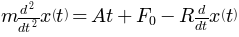

In [2]:
mass_times_acceleration = m * diff(x(t), t, 2)
net_force_on_object = (F0 + (A * t) - (R * diff(x(t), t)))
eq = Eq(mass_times_acceleration, net_force_on_object)
display(Eq(delta_F, F1 - F0))
display(Eq(A, delta_F / delta_t))
display(eq)
display(Eq(v(t), diff(x(t), t)))

Let's find the equations for position over time $x(t)$ and velocity over time $v(t)$.

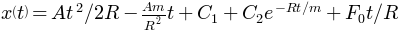

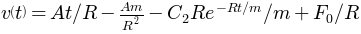

In [3]:
sol = dsolve(eq, x(t))
# "_expr_c" means expression with arbitrary constants
x_expr_c = sol.args[1]
v_expr_c = x_expr_c.diff(t)
display(Eq(x(t), x_expr_c))
display(Eq(v(t), v_expr_c))

Let's solve for the constants $C_1$ and $C_2$.

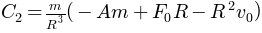

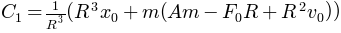

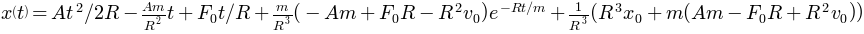

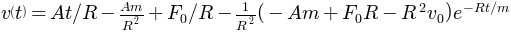

In [4]:
C1, C2 = symbols('C1 C2')
x_expr_temp = replace_symbols_in_expr(x_expr_c, (C1, C2))
v_expr_temp = replace_symbols_in_expr(v_expr_c, (C2,))

C2_expr = tuple(solveset(Eq(v0, v_expr_temp.subs(t, 0)), C2))[0]
C2_expr = simplify(C2_expr)
display(Eq(C2, C2_expr))
v_expr_final = v_expr_temp.subs(C2, C2_expr)

x_expr_temp = x_expr_temp.subs(C2, C2_expr)
C1_expr = tuple(solveset(Eq(x0, x_expr_temp.subs(t, 0)), C1))[0]
C1_expr = simplify(C1_expr)
display(Eq(C1, C1_expr))
x_expr_final = x_expr_temp.subs(C1, C1_expr)

print()
display(Eq(x(t), x_expr_final))
print()
display(Eq(v(t), v_expr_final))

Some basic checks:

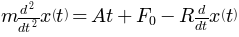

In [5]:
display(Eq(x(0), simplify(x_expr_final.subs(t, 0))))
display(Eq(v(0), simplify(v_expr_final.subs(t, 0))))

display(eq)

left_side = m * x_expr_final.diff(t, 2)
display(simplify(left_side))

right_side = (A*t) + F0 - (R * x_expr_final.diff(t))
display(simplify(right_side))

Eq(simplify(left_side), simplify(right_side))

I'm looking for a better or more efficient way to express the solution. When the simulator is executing, the values for $A$, $F_0$, $v_0$, and $x_0$ are what will change from timestep to timestep. The other values (including $t = \Delta{t}$) will be constant from one time step to another. So I want to factor out the variables from the constants.

Here is $x(t)$ in various forms, with a check to make sure I didn't make a mistake when rearranging terms.

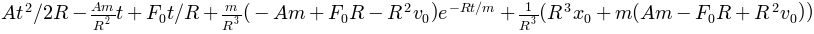

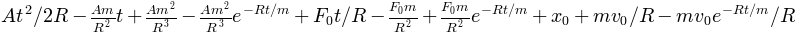

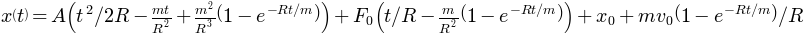

In [6]:
display(x_expr_final)
print()
display(simplify(x_expr_final))
print()

x_expr_2 = (
    A*(t**2/(2*R) - (m*t)/(R**2) + (m**2/R**3)*(1 - exp(-R*t/m))) +
    F0 * (t/R + (-m/R**2)*(1  - exp(-R*t/m))) +
    v0*(m/R)*(1 - exp(-R*t/m)) +
    x0
)
display(Eq(x(t), x_expr_2))
display(Eq(simplify(x_expr_final), simplify(x_expr_2)))

Next I'll rearrange $v(t)$ to make it easier to calculate each time step. Again, $A$, $F_0$, and $v_0$ are the only things that change from one time step to another. ($t = \Delta{t}$ each time step.)

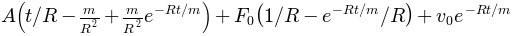

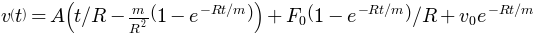

In [7]:
v_expr_2 = x_expr_2.diff(t)
display(v_expr_2)
v_expr_2 = A*(t/R - (m/R**2)*(1 - exp(-R*t/m))) + (F0/R)*(1 - exp(-R*t/m)) + v0 * exp(-R*t/m)
display(Eq(v(t), v_expr_2))
display(Eq(v_expr_final.expand(), simplify(v_expr_2)))